#  <center> Speech Depression Detection <center>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os
import sys
import shutil

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical

# import warnings
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
# warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio"

## Data Preparation


##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [3]:
base_source_directory = Ravdess
destination_directories = {
    'Depression': '/kaggle/working/ravdes/Depression/',
    'NonDepression': '/kaggle/working/ravdes/NonDepression/'
}

def copy_files_with_specific_number():
    count = 0
    for i in range(1, 25):
        actor_folder = f"Actor_{str(i).zfill(2)}"
        source_directory = os.path.join(base_source_directory, actor_folder)

        for category, base_destination_directory in destination_directories.items():
            destination_directory = os.path.join(base_destination_directory, actor_folder)

            if not os.path.exists(destination_directory):
                os.makedirs(destination_directory)

            for filename in os.listdir(source_directory):
                if '-' in filename:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        number = parts[2][:2]
                        if (category == 'Depression' and number in ['04', '05', '06', '07']) or \
                           (category == 'NonDepression' and number in ['01', '02', '03', '08']):
                            source_path = os.path.join(source_directory, filename)
                            destination_path = os.path.join(destination_directory, filename)
                            shutil.copy(source_path, destination_path)
                            count += 1
    print(f"Total files moved: {count}")

copy_files_with_specific_number()

Total files moved: 1440


In [4]:
records = []
for dirname, _, filenames in os.walk('/kaggle/working/ravdes'):
    for filename in filenames:
        records.append([filename, os.path.join(dirname,filename)])

data = pd.DataFrame(records, columns=['filename','Path'])
data['actor'] = data['Path'].apply(lambda x: re.findall("\w+_\d+",x)[0])
data = data[data['actor']!="audio_speech_actors_01"]
data.reset_index(inplace=True,drop=True)
data['type'] = data['filename'].apply(lambda x: re.split("-\d+\.wav",x)[0])
data

filename  \
0     03-01-06-01-02-02-03.wav   
1     03-01-07-02-01-01-03.wav   
2     03-01-04-02-02-02-03.wav   
3     03-01-05-01-01-02-03.wav   
4     03-01-07-01-02-01-03.wav   
...                        ...   
1435  03-01-02-02-01-02-09.wav   
1436  03-01-01-01-01-01-09.wav   
1437  03-01-03-01-02-02-09.wav   
1438  03-01-03-02-01-02-09.wav   
1439  03-01-01-01-02-02-09.wav   

                                                   Path     actor  \
0     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
1     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
2     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
3     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
4     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
...                                                 ...       ...   
1435  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   
1436  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   
1437  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   
1438  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   
1439  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   

                   type  
0     03-01-06-01-02-02  
1     03-01-07-02-01-01  
2     03-01-04-02-02-02  
3     03-01-05-01-01-02  
4     03-01-07-01-02-01  
...                 ...  
1435  03-01-02-02-01-02  
1436  03-01-01-01-01-01  
1437  03-01-03-01-02-02  
1438  03-01-03-02-01-02  
1439  03-01-01-01-02-02  

[1440 rows x 4 columns]

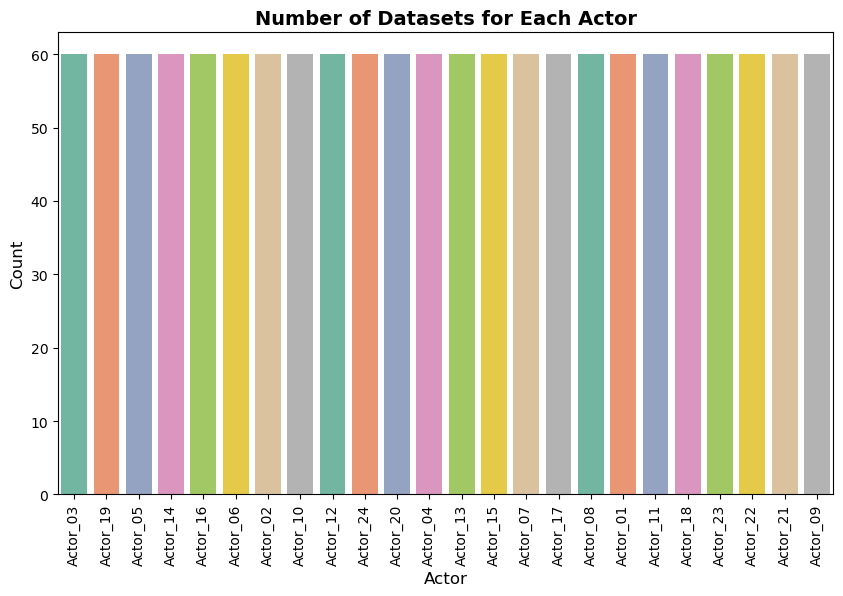

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x='actor', data=data, palette="Set2", order = data['actor'].value_counts().index)

plt.title('Number of Datasets for Each Actor', fontsize=14, fontweight='bold')
plt.xlabel('Actor', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)

plt.show()

In [6]:
def classify_emotion(emotion):
    if emotion in ['01', '02', '03', '08']:
        return 'NonDepression'
    elif emotion in ['04', '05', '06', '07']:
        return 'Depression'

def label_gender(actor):
    if int(actor) % 2 == 0:
        return 'female'
    else:
        return 'male'
data['Emotions'] = data['type'].apply(lambda x: classify_emotion(x.split('-')[2]))
data['gender'] = data['type'].apply(lambda x: label_gender(x.split('-')[5]))
data

filename  \
0     03-01-06-01-02-02-03.wav   
1     03-01-07-02-01-01-03.wav   
2     03-01-04-02-02-02-03.wav   
3     03-01-05-01-01-02-03.wav   
4     03-01-07-01-02-01-03.wav   
...                        ...   
1435  03-01-02-02-01-02-09.wav   
1436  03-01-01-01-01-01-09.wav   
1437  03-01-03-01-02-02-09.wav   
1438  03-01-03-02-01-02-09.wav   
1439  03-01-01-01-02-02-09.wav   

                                                   Path     actor  \
0     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
1     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
2     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
3     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
4     /kaggle/working/ravdes/Depression/Actor_03/03-...  Actor_03   
...                                                 ...       ...   
1435  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   
1436  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   
1437  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   
1438  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   
1439  /kaggle/working/ravdes/NonDepression/Actor_09/...  Actor_09   

                   type       Emotions  gender  
0     03-01-06-01-02-02     Depression  female  
1     03-01-07-02-01-01     Depression    male  
2     03-01-04-02-02-02     Depression  female  
3     03-01-05-01-01-02     Depression  female  
4     03-01-07-01-02-01     Depression    male  
...                 ...            ...     ...  
1435  03-01-02-02-01-02  NonDepression  female  
1436  03-01-01-01-01-01  NonDepression    male  
1437  03-01-03-01-02-02  NonDepression  female  
1438  03-01-03-02-01-02  NonDepression  female  
1439  03-01-01-01-02-02  NonDepression  female  

[1440 rows x 6 columns]

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

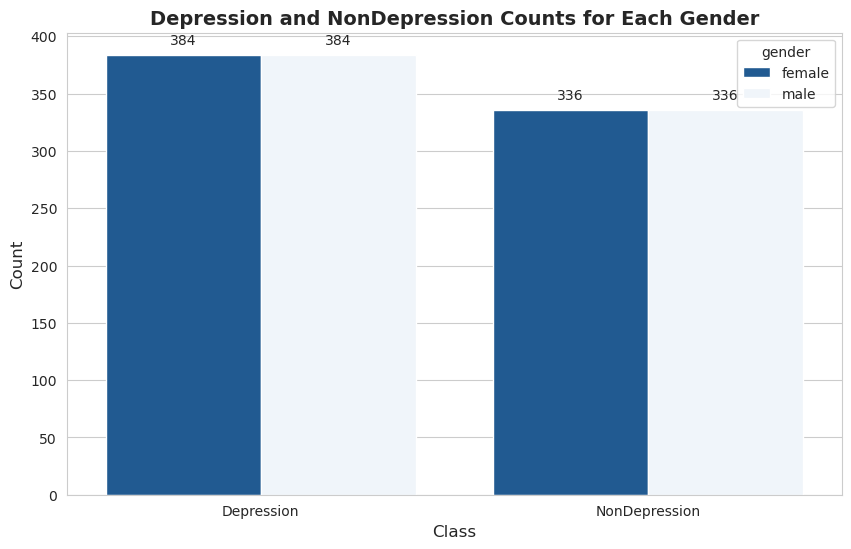

In [7]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
palette = ["#0f5aa3", "#eef5fc"]  # Biru tua dan biru muda
ax = sns.countplot(x='Emotions', hue='gender', data=data, palette=palette)

plt.title('Depression and NonDepression Counts for Each Gender', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()


In [9]:
def process_directory(directory, emotion_replacement):
    directory_list = os.listdir(directory)

    file_emotion = []
    file_path = []
    for dir in directory_list:
        actor = os.listdir(directory + '/' + dir)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            file_emotion.append(int(part[2]))
            file_path.append(directory + dir + '/' + file)

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    df = pd.concat([emotion_df, path_df], axis=1)

    df.Emotions.replace(emotion_replacement, inplace=True)
    return df

Ravdessdepre = "/kaggle/working/ravdes/Depression"
Ravdessnon = "/kaggle/working/ravdes/NonDepression"

Ravdessdepre_df = process_directory(Ravdessdepre, {4:'depressed', 5:'depressed', 6:'depressed', 7:'depressed'})
Ravdessnon_df = process_directory(Ravdessnon, {1:'non depressed', 2:'non depressed', 3:'non depressed', 8:'non depressed'})

# Menambahkan kolom 'Category' ke kedua DataFrame
Ravdessdepre_df['Category'] = 'Depressed'
Ravdessnon_df['Category'] = 'Non-Depressed'

# Menggabungkan kedua DataFrame
data_path = pd.concat([Ravdessdepre_df, Ravdessnon_df], keys=['Depressed', 'Non-Depressed'], axis=0)
data_path

Emotions  \
Depressed     0        depressed   
              1        depressed   
              2        depressed   
              3        depressed   
              4        depressed   
...                          ...   
Non-Depressed 667  non depressed   
              668  non depressed   
              669  non depressed   
              670  non depressed   
              671  non depressed   

                                                                Path  \
Depressed     0    /kaggle/working/ravdes/DepressionActor_03/03-0...   
              1    /kaggle/working/ravdes/DepressionActor_03/03-0...   
              2    /kaggle/working/ravdes/DepressionActor_03/03-0...   
              3    /kaggle/working/ravdes/DepressionActor_03/03-0...   
              4    /kaggle/working/ravdes/DepressionActor_03/03-0...   
...                                                              ...   
Non-Depressed 667  /kaggle/working/ravdes/NonDepressionActor_09/0...   
              668  /kaggle/working/ravdes/NonDepressionActor_09/0...   
              669  /kaggle/working/ravdes/NonDepressionActor_09/0...   
              670  /kaggle/working/ravdes/NonDepressionActor_09/0...   
              671  /kaggle/working/ravdes/NonDepressionActor_09/0...   

                        Category  
Depressed     0        Depressed  
              1        Depressed  
              2        Depressed  
              3        Depressed  
              4        Depressed  
...                          ...  
Non-Depressed 667  Non-Depressed  
              668  Non-Depressed  
              669  Non-Depressed  
              670  Non-Depressed  
              671  Non-Depressed  

[1440 rows x 3 columns]

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

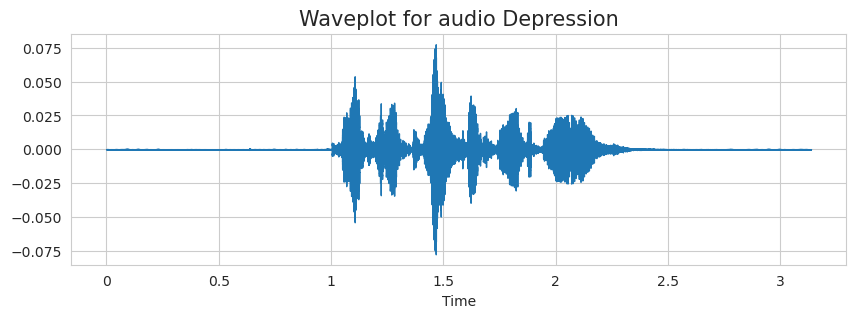

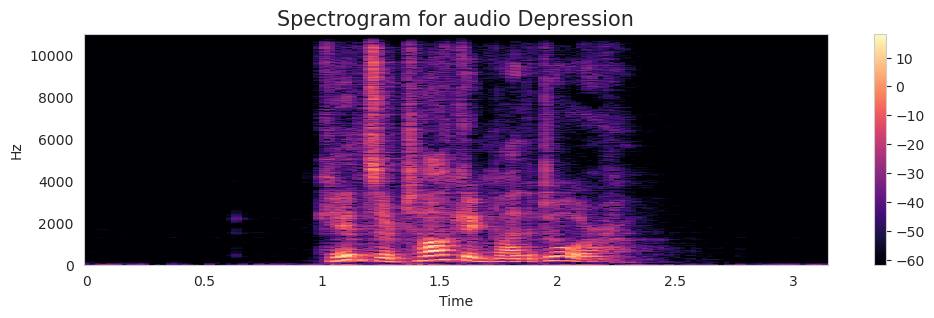

In [11]:
emotion = 'Depression'
path = "/kaggle/working/ravdes/Depression/Actor_05/03-01-06-01-01-01-05.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

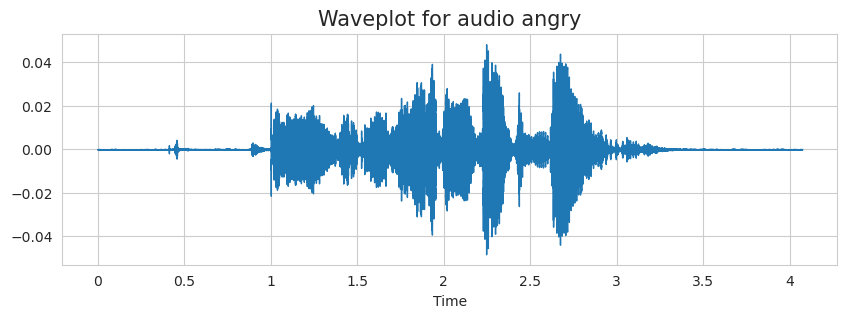

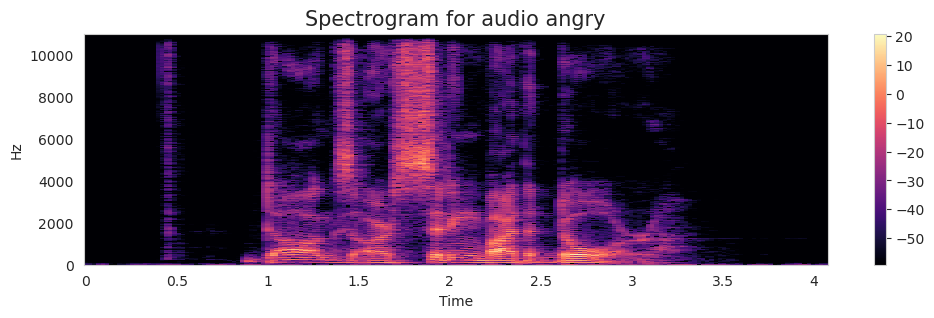

In [12]:
emotion='angry'
path = '/kaggle/working/ravdes/Depression/Actor_05/03-01-05-01-02-01-05.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

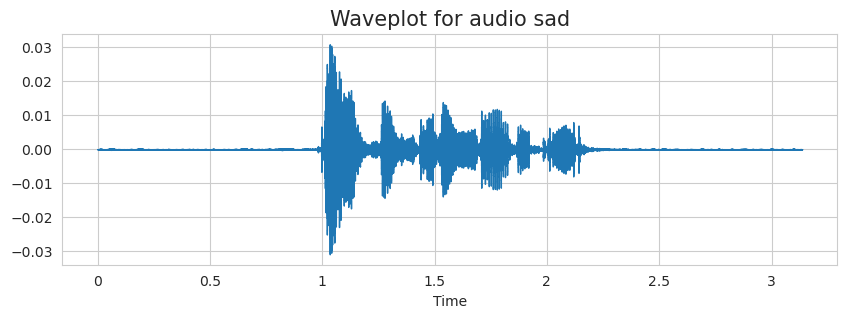

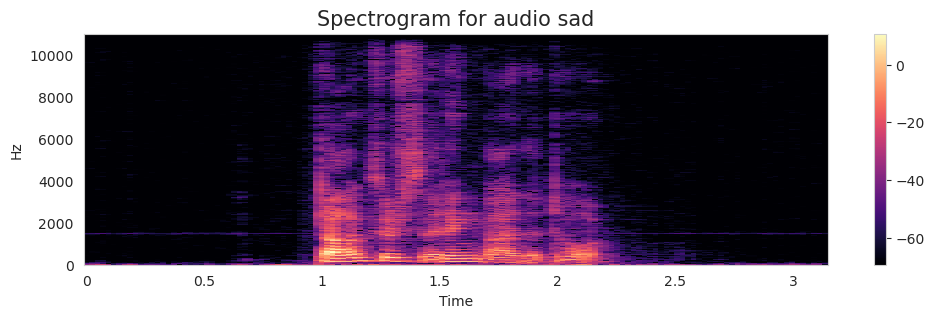

In [13]:
emotion='sad'
path = '/kaggle/working/ravdes/Depression/Actor_05/03-01-04-02-02-02-05.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

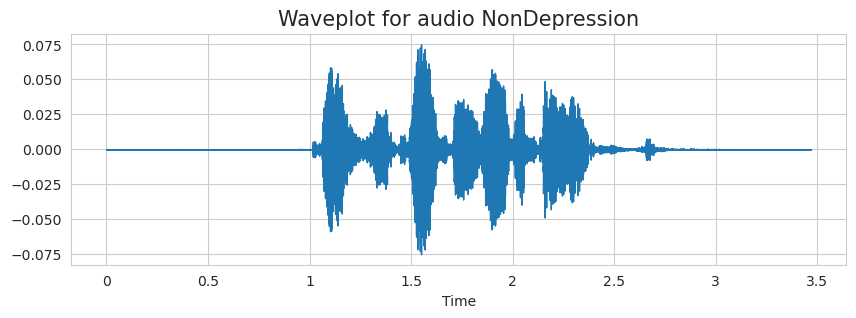

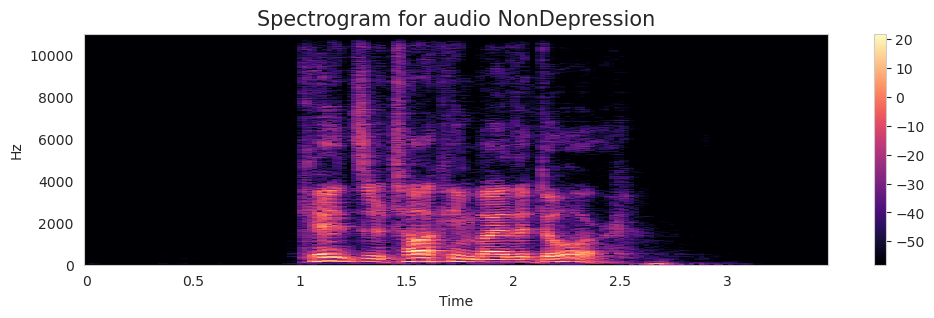

In [14]:
emotion='NonDepression'
path = '/kaggle/working/ravdes/NonDepression/Actor_01/03-01-03-01-01-02-01.wav'
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [16]:
depression_data = []
non_depression_data = []
directories = [
    '/kaggle/working/ravdes/Depression',
    '/kaggle/working/ravdes/NonDepression'
]

def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, n_steps=0):
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=n_steps)

for directory in directories:
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.wav'):
                filepath = os.path.join(root, filename)
                if 'depression' in filepath.lower():
                    depression_data.append(filepath)
                elif 'non depression' in filepath.lower():
                    non_depression_data.append(filepath)

#### 1. Simple Audio

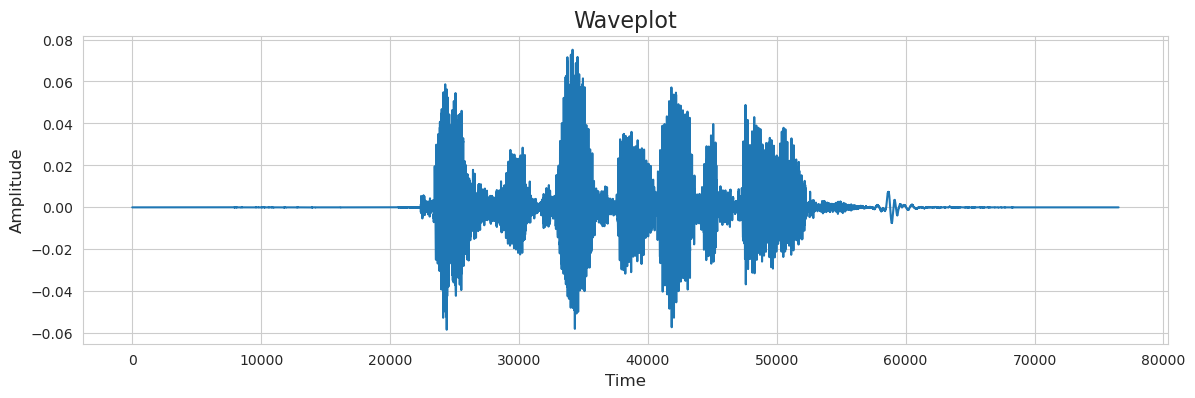

In [17]:
pathnew = '/kaggle/working/ravdes/NonDepression/Actor_05/03-01-01-01-02-01-05.wav'

plt.figure(figsize=(14, 4))
plt.plot(data)
plt.title('Waveplot', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(pathnew)

#### 2. Noise Injection

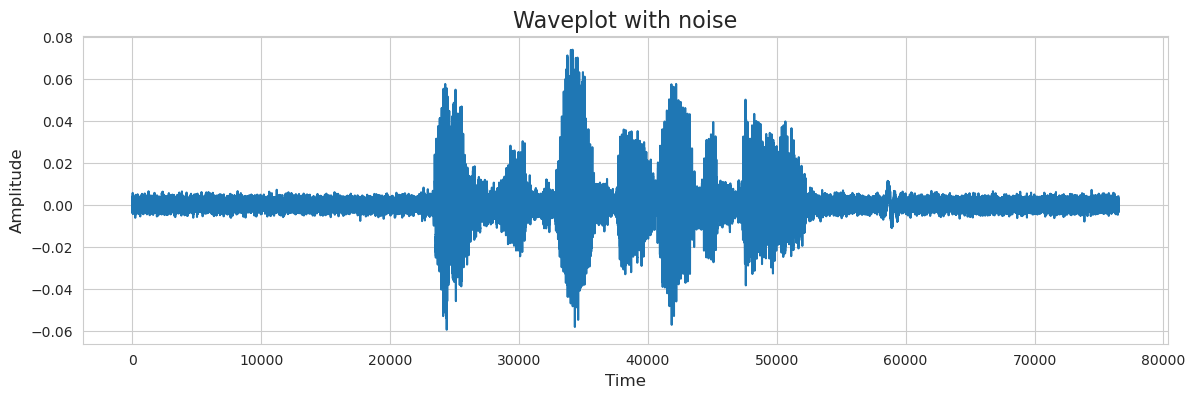

In [18]:
x = noise(data)
plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot with noise', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()
data,sample_rate = librosa.load(pathnew)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

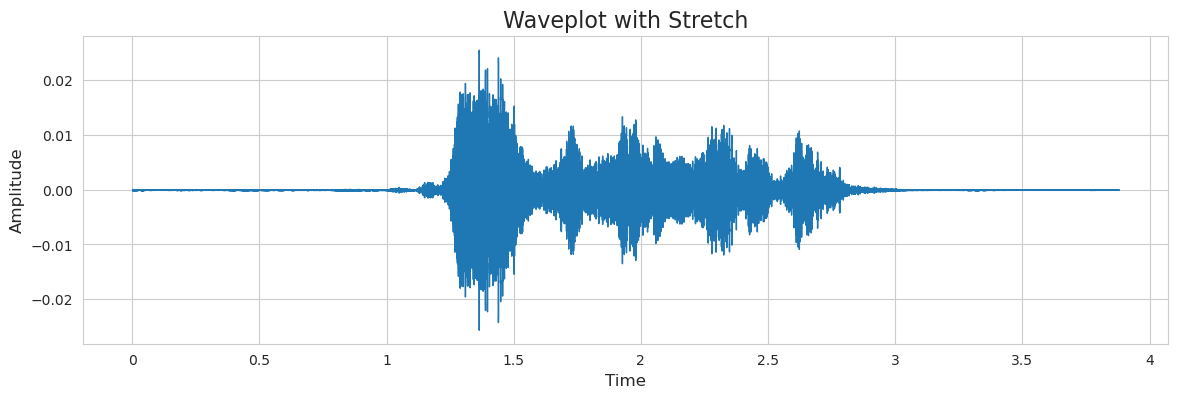

In [19]:
x = stretch(data, rate=0.8)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Waveplot with Stretch', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(x, rate=sample_rate)

#### 4. Shifting

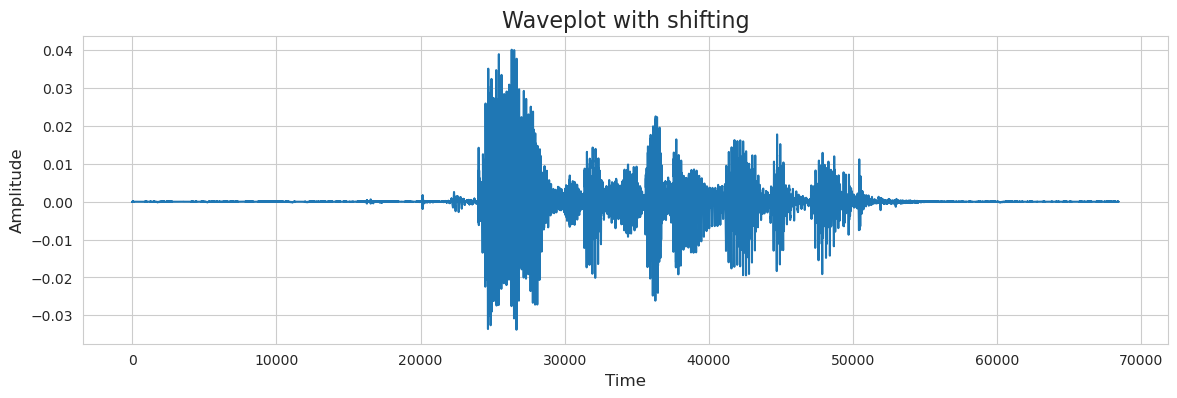

In [20]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with shifting', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()
Audio(x, rate=sample_rate)


#### 5. Pitch

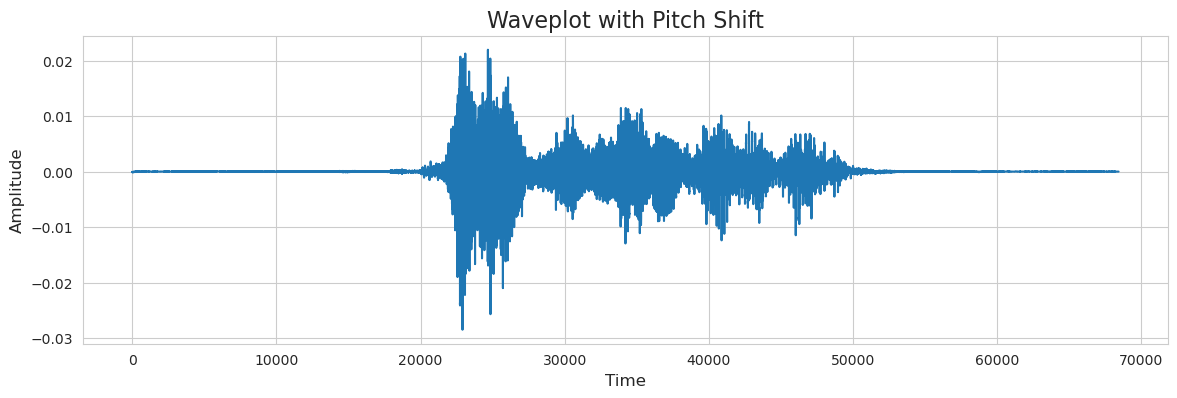

In [21]:
x = pitch(data, n_steps=1)

plt.figure(figsize=(14, 4))
plt.plot(x)
plt.title('Waveplot with Pitch Shift', size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(x, rate=sample_rate)


- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [26]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_contrast))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(data), sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))

    # Rolloff
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, rolloff))

    # Zero Crossing Rate Variance
    zcr_var = np.var(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr_var))

    return result

def get_features(pathbaru, sample_rate):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, _ = librosa.load(pathbaru, sr=sample_rate, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))  # stacking vertically

    return result

In [27]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    path = path.replace("Actor_", "/Actor_")
    feature = get_features(path, sample_rate)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

NameError: name 'data_path' is not defined

In [24]:
len(X), len(Y), data_path.Path.shape

NameError: name 'data_path' is not defined

In [28]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features

Empty DataFrame
Columns: [labels]
Index: []

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [29]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [30]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [31]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

NameError: name 'x_train' is not defined

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

## Modelling cnn

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=70, validation_data=(x_test, y_test), callbacks=[rlrp])

In [ ]:
# Menampilkan akurasi model pada data uji
accuracy = model.evaluate(x_test, y_test)[1] * 100
print("Akurasi model pada data uji: {:.2f}%".format(accuracy))

# Membuat grafik untuk pelatihan dan pengujian model
epochs = [i for i in range(70)]

# Menyiapkan subplot dan ukuran gambar
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

# Mengambil data pelatihan
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# Mengambil data pengujian
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Grafik untuk kehilangan (loss)
ax[0].plot(epochs, train_loss, label='Training loss')
ax[0].plot(epochs, test_loss, label='Testing loss')
ax[0].set_title('Training & testing loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Grafik untuk akurasi
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

# Menampilkan grafik
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.